# Import packages

In [132]:
import os
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load data

In [133]:
nlp = spacy.load("en_core_web_sm")

In [134]:
# Load the environment variables
load_dotenv()

# Get the paths to the data
data_dir = os.getenv("DATA_DIR")
articles_dir = os.path.join(data_dir, "articles")

# Load the main dataset
df = pd.read_csv(f"{data_dir}/article_info_V2.csv", index_col=0, parse_dates=[1])

# Load the external dataset
external_df = pd.read_csv(f"{data_dir}/other-articles.csv", index_col=0, parse_dates=[1], sep=";")

# Cleaning

In [135]:
# Drop unused columns
df.drop(columns=["Author", "Type", "Keywords"], inplace=True)

# Drop rows with empty date values
df.dropna(subset=["Date"], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Remove the url column from the external dataset
external_df.drop(columns=["Url"], inplace=True)

# Merging datasets

In [136]:
# Add the external dataset to the main dataset
df = pd.concat([df, external_df])

# Reset the index
df.reset_index(drop=True, inplace=True)

# Clear the external dataset variable
del external_df

# Remove duplicates

In [137]:
# Count the number of entries before duplicate removal
entries_count = len(df)

# remove duplicate entries by title and date
df.drop_duplicates(subset=["Title", "Date"], keep="first", inplace=True)

# Drop the date column
df.drop(columns=["Date"], inplace=True)

# Print the number of deleted entries
print(f"Removed {entries_count - len(df)} duplicate entries.")

# Clear the entries count variable
del entries_count

Removed 3 duplicate entries.


# Parse target

In [138]:
# Define functions to parse target
def clean_string(str):
    # Make the string lowercase
    str = str.lower()
    # Remove all non-alphanumeric characters
    str = re.sub(r"[^\w\s]", "", str)
    # Remove the leading and trailing spaces
    return str.strip()

def parse_tags(str):
    # Split the string on each comma
    raw_list = str.split(",")
    # Clean every string in the list
    return list(map(clean_string, raw_list))

In [139]:
# Convert the raw string values of the Tags column to lists of strings
df["Tags"] = df["Tags"].apply(parse_tags)

In [140]:
# Clear the cleaning and parsing functions
del clean_string, parse_tags

# Load articles

In [141]:
# Article loading function
def load_article(title):
    # Create filename from title
    file_name = f"{title}.txt"
    # Get the path of the article
    file_path = os.path.join(articles_dir, file_name)
    try:
        # Attempt to read the article
        file = open(file_path, "r", encoding="utf-8")
    except:
        # If the article could not be read, return None
        return None
    # Read the contents of the article
    contents = file.read()
    # Close the file
    file.close()
    # Return the contents of the article
    return contents

In [142]:
# Load the articles
df["Contents"] = df["Title"].apply(load_article)

# Clear the article loading function
del load_article

In [143]:
# Count the number of entries in the dataframe
entries_count = len(df)

# Remove rows without article contents
df.dropna(subset=["Contents"], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Print the number of deleted entries
print(f"Removed {entries_count - len(df)} entries without article contents.")

# Clear the entries count variable
del entries_count

Removed 42 entries without article contents.


# Create categories from tags

In [144]:
unique_tags = []
for tag_list in df["Tags"]:
    for tag in tag_list:
        if tag not in unique_tags:
            unique_tags.append(tag)

In [145]:
# Load the custom categories dataset
custom_categories = pd.read_csv(f"{data_dir}/custom-categories.csv", sep=";")

# After receiving feedback from SKC, we decided to drop the following categories:
custom_categories.drop(columns=["People", "Places", "Criminal groups"], inplace=True)

# Define a function to parse the custom categories into a list of strings
def load_category(name):
    try:
        return custom_categories[name].dropna().tolist()
    except:
        return None

In [146]:
# Initiate the category dictionary
categories = {}

# Iterate over these custom_categories columns
for category_name in custom_categories.columns:
    # Load the category
    categories[category_name] = load_category(category_name)

In [147]:
# Create a new column for the category
df["Category"] = ""

# Iterate over the dataframe
for index, row in df.iterrows():
    # Get the tags of the current row
    tag_list = row["Tags"]
    # Create a dictionary for the counters of the categories for this article
    counters = {}
    # Iterate over every tag in the tag list
    for tag in tag_list:
        # Iterate over the categories
        for category_name in categories:
            # Get the current category
            category = categories[category_name]
            # Check if the tag is in the category list
            if tag in category:
                # If it is, add it to the counters dictionary
                if category_name not in counters:
                    counters[category_name] = 1
                else:
                    counters[category_name] += 1    
    # Get the category with the highest counter and assign it to the row
    if len(counters) == 0:
        row["Category"] = "Other"
    else:
        row["Category"] = max(counters, key=counters.get)

# Drop the tags column

In [148]:
df.drop(columns=["Tags"], inplace=True)

# Visualizations

In [149]:
categories = df["Category"].value_counts()

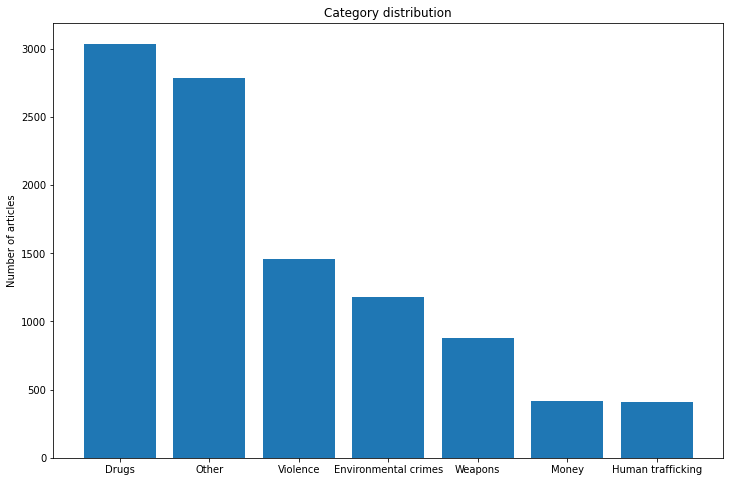

In [150]:
plt.figure(figsize=(12, 8))
plt.title("Category distribution")
plt.ylabel("Number of articles")
plt.bar(categories.index, categories.values)
plt.show()

In [152]:
df.head(10)

,Title,Contents,Category
0,Did Anti-Drug Crusade Lead to Haiti President'...,An explosive new report suggests that the high...,Drugs
1,Colombian Prosecutors Dismiss Memo Fantasma Li...,Prosecutors in Colombia have dismissed a crimi...,Other
2,Could US Anti-Violence Models Work in Latin Am...,Efforts to reduce gang violence are often thou...,Other
3,How Mexican Cartels Settled in Canada,The story of the Mexican cartels and their inf...,Drugs
4,Haiti Gangs Profit from Targeting Religious Gr...,Religious groups are among the final instituti...,Other
5,Peru's Anti-Corruption Crusade Grows Weaker,Authorities in Peru have dismantled a complex ...,Other
6,"Top Ex-FARC Commanders, El Paisa and Romaña, C...",Colombia's Defense Minister has reported that ...,Drugs
7,"US Blacklists El Salvador Officials, Bolsterin...",In what appears to be a shot at El Salvador Pr...,Other
8,"Laborers from Mexico, Central America Exploite...",A transnational labor trafficking network brou...,Drugs
9,FARC Dissidents First to be Charged Under New ...,Colombia is rolling out a new strategy to figh...,Environmental crimes


In [ ]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

doc = nlp(load_article(df['Title'][0], load_contents=True))

# Write multiple patterns to find if an article contains cocaine etc.
pattern = [
[{"POS": "ADJ"},{"TEXT": "cocaine"},{"POS": "NOUN", "OP": "?"}],
[{"TEXT": "drug"},{"POS": "NOUN"}]
]

# Add the pattern to the matcher and apply the matcher to the doc
matcher.add("DETERMINE COCAINE", [pattern][0])
matches = matcher(doc)
print("Total matches found:", len(matches))

# Iterate over the matches and print the span text
for match_id, start, end in matches:
    print("Match found:", doc[start:end].text)